# 9. 폐렴아 기다려라!

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(action="ignore")

## 실험환경 설정

데이터가 위치한 경로 정보와 훈련용 이미지의 크기 등을 준비합니다.
- `AUTOTUNE`: 모델이 학습 데이터를 소비하는 동안 다음 데이터를 준비하는 `prefetch` 크기를 CPU의 성능에 따라 자동으로 결정합니다.

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

ROOT_PATH = os.path.join(os.getenv("HOME"), "aiffel")
TRAIN_PATH = ROOT_PATH + "/chest_xray/data/train/*/*"
VAL_PATH = ROOT_PATH + "/chest_xray/data/val/*/*"
TEST_PATH = ROOT_PATH + "/chest_xray/data/test/*/*"

IMAGE_SIZE = [180, 180]
BATCH_SIZE = 16
EPOCHS = 25

## 데이터 준비

훈련, 테스트, 검증을 위한 데이터의 숫자를 확인합니다.

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train 데이터와 비교하여 validation 데이터가 매우 적습니다.  
train 데이터와 validation 데이터를 모아서 섞고 다시 80:20의 비율로 나눕니다.

In [4]:
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

train_size = math.floor(len(filenames) * 0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


train 데이터는 5216에서 4185로, validation 데이터는 16에서 1047로 재분배하였습니다.

정상 이미지와 폐렴 이미지의 파일 경로를 확인합니다.

In [5]:
print(f"Normal image path   : {filenames[0]}")
print(f"Pneumonia image path: {filenames[2000]}")

Normal image path   : /aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path: /aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


정상 이미지의 파일 경로에는 "NORMAL"이라는 단어가 포함되어 있고, 폐렴 이미지의 파일 경로에는 "PNEUMONIA"라는 단어가 포함되어 있습니다.  
해당 정보를 이용하여 훈련 데이터에 정상 이미지와 폐렴 이미지가 몇 장씩 포함되어 있는지 확인합니다.

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len(
    [filename for filename in train_filenames if "PNEUMONIA" in filename]
)
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


훈련 데이터와 검증 데이터의 파일 경로를 이용하여 Dataset을 생성합니다.

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


폐렴이면 True, 폐렴이 아니면 False를 반환하도록 하여 라벨링을 수행하는 함수를 작성합니다.

In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"

이미지를 불러와 라벨을 부여하고, 원하는 형태로 변형하는 함수를 작성합니다.

In [10]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img


def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

전체 데이터셋에 라벨링 부여 및 크기 변경을 적용합니다.
- `AUTOTUNE`: CPU의 성능에 따라 자동으로 Dataset 인스턴스에 map을 적용하는 함수를 여러 개 호출합니다.

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

임의의 이미지 1개를 확인한 결과, 이미지 크기 변경과 라벨부여가 정상적으로 수행되었음을 확인할 수 있습니다.

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


테스트 이미지 데이터에 대해서도 동일한 과정을 진행합니다.

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


데이터셋을 임의의 순서로 제공하고, 배치 사이즈에 맞게 제공하도록 만들어 줍니다.

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 데이터 시각화

임의의 데이터 16개를 확인합니다.

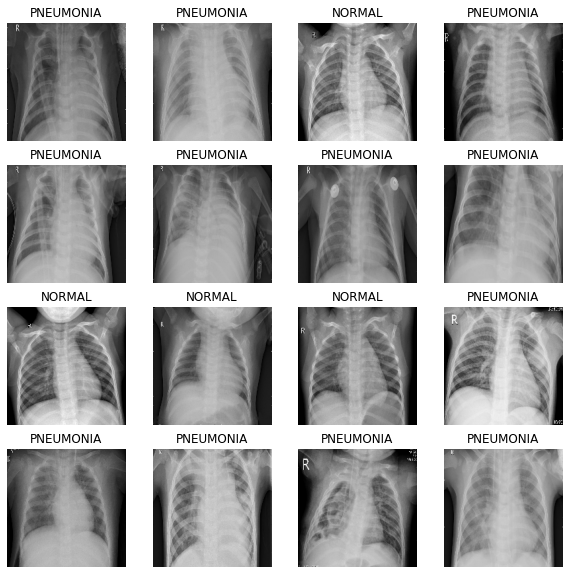

In [15]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4, math.ceil(BATCH_SIZE / 4), n + 1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

이미지에 좌우가 표기되어 있지만, 모델을 통해 폐렴을 판단하는 기준은 True | False 이기 때문에 모델의 성능이 충분하지 않을 때 데이터 증강을 시도할 수 있을 것으로 보입니다.  

## CNN 모델링

다수의 Convolution 레이어와 Dense 레이어를 가진 모델의 생성을 위해 다수의 계층으로 이루어진 'block'을 생성하는 함수를 선언합니다.

In [16]:
def conv_block(filters, batchnorm=True):
    seq = []
    seq.append(
        tf.keras.layers.SeparableConv2D(filters, 3, activation="relu", padding="same")
    )
    seq.append(
        tf.keras.layers.SeparableConv2D(filters, 3, activation="relu", padding="same")
    )
    if batchnorm:
        seq.append(tf.keras.layers.BatchNormalization())
    seq.append(tf.keras.layers.MaxPool2D())
    block = tf.keras.Sequential(seq)
    return block

In [17]:
def dense_block(units, dropout_rate, batchnorm=True):
    seq = []
    seq.append(tf.keras.layers.Dense(units, activation="relu"))
    if batchnorm:
        seq.append(tf.keras.layers.BatchNormalization())
    if dropout_rate > 0:
        seq.append(tf.keras.layers.Dropout(dropout_rate))

    block = tf.keras.Sequential(seq)
    return block

In [18]:
def build_model(dropout=True, batchnorm=True):
    if dropout:
        prob = [0.2, 0.7, 0.5, 0.3]
    else:
        prob = [0] * 4

    seq = []
    seq = seq + [
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255),
        tf.keras.layers.Conv2D(16, 3, activation="relu", padding="same"),
        tf.keras.layers.Conv2D(16, 3, activation="relu", padding="same"),
        tf.keras.layers.MaxPool2D(),
        conv_block(32, batchnorm),
        conv_block(64, batchnorm),
        conv_block(128, batchnorm),
    ]
    if dropout:
        seq.append(tf.keras.layers.Dropout(prob[0]))
    seq.append(conv_block(256))
    if dropout:
        seq.append(tf.keras.layers.Dropout(prob[0]))
    seq = seq + [
        tf.keras.layers.Flatten(),
        dense_block(512, prob[1], batchnorm),
        dense_block(128, prob[2], batchnorm),
        dense_block(64, prob[3], batchnorm),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]

    model = tf.keras.Sequential(seq)
    return model

20 epoch 동안 validation loss의 감소가 없다면 학습이 제대로 진행되괴 있지 않은 상태이므로 훈련을 중단하도록 설정합니다.

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

METRICS = [
    "accuracy",
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
]

stopper = EarlyStopping(patience=20, restore_best_weights=True)

## 모델 훈련

- 질병을 진단하는 작업이기 때문에 accuracy와 더불어 precision과 recall도 평가요소로 사용합니다.  
- 가장 낮은 validation loss를 기록한 모델을 최종 모델로 사용할 수 있도록 체크포인트를 사용합니다.

In [20]:
weight_path = "checkpoint/weights_base.h5"
checkpoint = ModelCheckpoint(
    filepath=weight_path, save_best_only=True, save_weights_only=True
)


with tf.device("/GPU:0"):
    model = build_model()
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=METRICS)
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        callbacks=[stopper, checkpoint],
    )

Epoch 1/25
261/261 [==============================] - 85s 193ms/step - loss: 0.6942 - accuracy: 0.6219 - precision: 0.7521 - recall: 0.7334 - val_loss: 0.5776 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 188ms/step - loss: 0.3208 - accuracy: 0.8654 - precision: 0.9122 - recall: 0.9063 - val_loss: 1.0972 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 187ms/step - loss: 0.2096 - accuracy: 0.9195 - precision: 0.9474 - recall: 0.9443 - val_loss: 0.3772 - val_accuracy: 0.8125 - val_precision: 0.7971 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 49s 190ms/step - loss: 0.1917 - accuracy: 0.9260 - precision: 0.9469 - recall: 0.9540 - val_loss: 0.2138 - val_accuracy: 0.8981 - val_precision: 0.8798 - val_recall: 0.9974
Epoch 5/25
261/261 [==============================] - 49s 189ms/step - loss: 0.1795 - accura

## 결과 확인 및 시각화

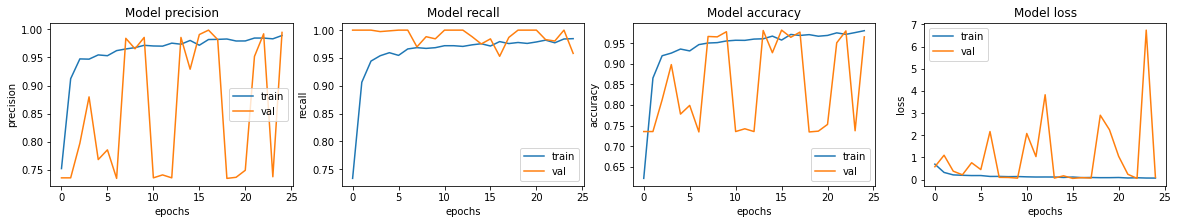

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [22]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(
    f"Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}"
)

39/39 [==============================] - 4s 110ms/step - loss: 0.8739 - accuracy: 0.7965 - precision: 0.7700 - recall: 0.9615
Loss: 0.8738957047462463,
Accuracy: 0.7964743375778198,
Precision: 0.7700205445289612,
Recall: 0.9615384340286255


## 데이터 불균형 문제 해결에 따른 성능 변화

정상 이미지와 폐렴 이미지 데이터의 크기는 2배 이상 차이가 났습니다. 이렇게 클래스 간 데이터의 양이 불균형한 경우, 샘플 수가 많은 데이터를 잘 예측하도록 편향되어 학습될 가능성이 있습니다.  
성능 개선을 위해 데이터의 숫자 비율을 사용하여 훈련 과정에 반영합니다.

In [23]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for NORMAL: {:.2f}".format(weight_for_0))
print("Weight for PNEUMONIA: {:.2f}".format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [24]:
weight_path = "checkpoint/weights_balance.h5"
checkpoint = ModelCheckpoint(
    filepath=weight_path, save_best_only=True, save_weights_only=True
)

with tf.device("/GPU:0"):
    model = build_model()
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=METRICS)
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[stopper, checkpoint],
    )

Epoch 1/25
261/261 [==============================] - 56s 182ms/step - loss: 0.8492 - accuracy: 0.5067 - precision: 0.7548 - recall: 0.5552 - val_loss: 0.7751 - val_accuracy: 0.2644 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
261/261 [==============================] - 46s 178ms/step - loss: 0.5819 - accuracy: 0.6595 - precision: 0.8784 - recall: 0.6287 - val_loss: 1.0749 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 47s 180ms/step - loss: 0.2762 - accuracy: 0.8812 - precision: 0.9701 - recall: 0.8670 - val_loss: 0.7135 - val_accuracy: 0.7375 - val_precision: 0.7372 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 48s 183ms/step - loss: 0.2442 - accuracy: 0.9052 - precision: 0.9676 - recall: 0.9029 - val_loss: 0.1138 - val_accuracy: 0.9654 - val_precision: 0.9893 - val_recall: 0.9634
Epoch 5/25
261/261 [==============================] - 48s 185ms/step - loss: 0.1919 

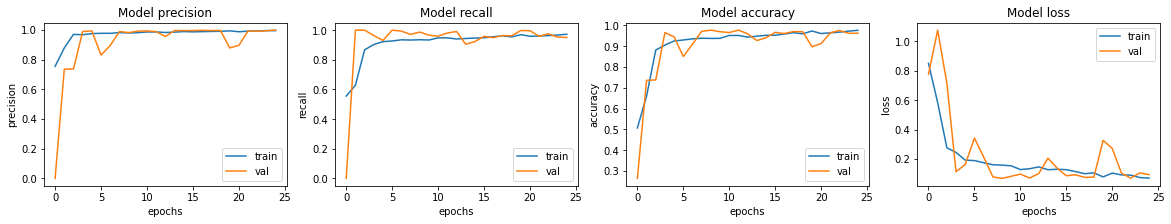

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [26]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(
    f"Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}"
)

39/39 [==============================] - 4s 103ms/step - loss: 0.6296 - accuracy: 0.8606 - precision: 0.8301 - recall: 0.9769
Loss: 0.6295910477638245,
Accuracy: 0.8605769276618958,
Precision: 0.8300653696060181,
Recall: 0.9769230484962463


## 배치 사이즈 변경에 따른 성능 변화

배치 사이즈를 16에서 32로 증가시키고 성능 변화를 확인합니다.

In [27]:
BATCH_SIZE = 32
train_ds._batch_size = BATCH_SIZE
val_ds._batch_size = BATCH_SIZE
test_ds._batch_size = BATCH_SIZE


weight_path = "checkpoint/weights_batch.h5"
checkpoint = ModelCheckpoint(
    filepath=weight_path, save_best_only=True, save_weights_only=True
)

with tf.device("/GPU:0"):
    model = build_model()
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=METRICS)
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[stopper, checkpoint],
    )

Epoch 1/25
130/130 [==============================] - 38s 222ms/step - loss: 0.9044 - accuracy: 0.5000 - precision: 0.7723 - recall: 0.5964 - val_loss: 0.7633 - val_accuracy: 0.2637 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
130/130 [==============================] - 28s 220ms/step - loss: 0.8356 - accuracy: 0.4918 - precision: 0.7310 - recall: 0.4948 - val_loss: 0.7588 - val_accuracy: 0.2598 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
130/130 [==============================] - 28s 218ms/step - loss: 0.7895 - accuracy: 0.4726 - precision: 0.7249 - recall: 0.4673 - val_loss: 0.6663 - val_accuracy: 0.7148 - val_precision: 0.7148 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 28s 218ms/step - loss: 0.7729 - accuracy: 0.4745 - precision: 0.7228 - recall: 0.4767 - val_loss: 0.7263 - val_accuracy: 0.2852 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
130/130 [==============================] - 29s 225ms/step

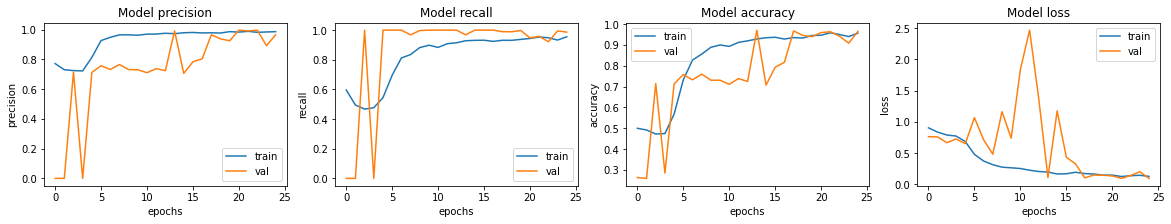

In [28]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [29]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(
    f"Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}"
)

39/39 [==============================] - 4s 105ms/step - loss: 0.7726 - accuracy: 0.7388 - precision: 0.7083 - recall: 0.9897
Loss: 0.7725569009780884,
Accuracy: 0.7387820482254028,
Precision: 0.7082569003105164,
Recall: 0.9897435903549194


배치 사이즈를 64로 설정하고 성능 변화를 확인합니다.

In [30]:
BATCH_SIZE = 64
train_ds._batch_size = BATCH_SIZE
val_ds._batch_size = BATCH_SIZE
test_ds._batch_size = BATCH_SIZE


weight_path = "checkpoint/weights_batch_64.h5"
checkpoint = ModelCheckpoint(
    filepath=weight_path, save_best_only=True, save_weights_only=True
)

with tf.device("/GPU:0"):
    model = build_model()
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=METRICS)
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[stopper, checkpoint],
    )

Epoch 1/25
65/65 [==============================] - 27s 283ms/step - loss: 0.8742 - accuracy: 0.5250 - precision: 0.7420 - recall: 0.6743 - val_loss: 0.8235 - val_accuracy: 0.2461 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
65/65 [==============================] - 18s 273ms/step - loss: 0.8736 - accuracy: 0.5231 - precision: 0.7518 - recall: 0.5362 - val_loss: 0.8466 - val_accuracy: 0.2734 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
65/65 [==============================] - 18s 276ms/step - loss: 0.7901 - accuracy: 0.5115 - precision: 0.7675 - recall: 0.4857 - val_loss: 0.8637 - val_accuracy: 0.2344 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
65/65 [==============================] - 18s 286ms/step - loss: 0.5966 - accuracy: 0.6452 - precision: 0.8895 - recall: 0.5953 - val_loss: 0.6383 - val_accuracy: 0.7266 - val_precision: 0.7266 - val_recall: 1.0000
Epoch 5/25
65/65 [==============================] - 19s 292ms/step - loss: 0

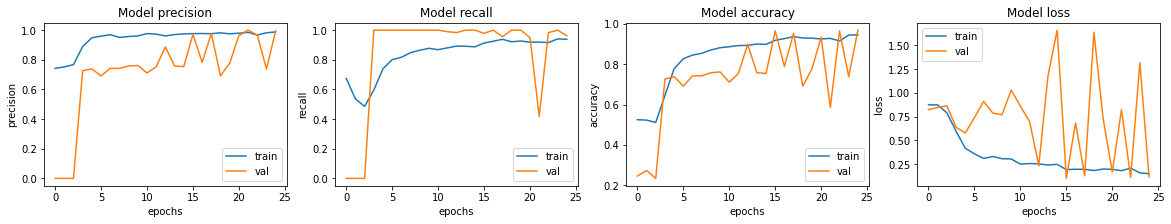

In [31]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [32]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(
    f"Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}"
)

39/39 [==============================] - 4s 98ms/step - loss: 0.4352 - accuracy: 0.8045 - precision: 0.7839 - recall: 0.9487
Loss: 0.4352179169654846,
Accuracy: 0.8044871687889099,
Precision: 0.7838982939720154,
Recall: 0.9487179517745972


In [33]:
BATCH_SIZE = 16
train_ds._batch_size = BATCH_SIZE
val_ds._batch_size = BATCH_SIZE
test_ds._batch_size = BATCH_SIZE

## 정규화 적용 여부에 따른 성능 변화

앞서 사용한 모델에는 정규화를 위해 Dropout과 Batch Normalization 기법을 모두 사용하였습니다.  
각 기법이 성능에 미치는 영향을 확인하기 위해 정규화 기법을 하나만 적용하는 실험을 진행합니다.

### Dropout 적용, BatchNorm 미적용

In [34]:
weight_path = "checkpoint/weights_nonBN.h5"
checkpoint = ModelCheckpoint(filepath=weight_path, save_best_only=True, save_weights_only=True)

with tf.device("/GPU:0"):
    model = build_model(batchnorm=False)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=METRICS)
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[stopper, checkpoint],
    )


Epoch 1/25
261/261 [==============================] - 57s 188ms/step - loss: 0.6985 - accuracy: 0.5125 - precision: 0.7432 - recall: 0.5851 - val_loss: 0.7114 - val_accuracy: 0.2654 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
261/261 [==============================] - 49s 186ms/step - loss: 0.6994 - accuracy: 0.4945 - precision: 0.7575 - recall: 0.4715 - val_loss: 0.7257 - val_accuracy: 0.2654 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
261/261 [==============================] - 49s 187ms/step - loss: 0.6960 - accuracy: 0.4890 - precision: 0.7434 - recall: 0.4776 - val_loss: 0.7045 - val_accuracy: 0.2625 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
261/261 [==============================] - 49s 187ms/step - loss: 0.6977 - accuracy: 0.4825 - precision: 0.7473 - recall: 0.4598 - val_loss: 0.7039 - val_accuracy: 0.2654 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
261/261 [==============================] - 49s 19

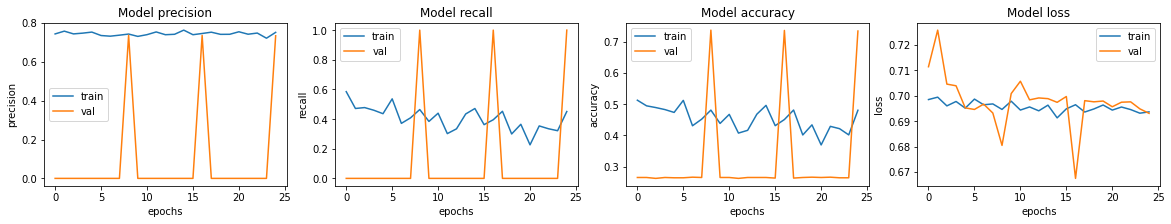

In [35]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [36]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(
    f"Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}"
)

39/39 [==============================] - 4s 105ms/step - loss: 0.6931 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.6930940747261047,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


### Dropout 미적용, BatchNorm 적용

In [37]:
weight_path = "checkpoint/weights_nonDrop.h5"
checkpoint = ModelCheckpoint(filepath=weight_path, save_best_only=True, save_weights_only=True)

with tf.device("/GPU:0"):
    model = build_model(dropout=False)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=METRICS)
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[stopper, checkpoint],
    )


Epoch 1/25
261/261 [==============================] - 57s 183ms/step - loss: 0.2373 - accuracy: 0.9054 - precision: 0.9109 - recall: 0.9090 - val_loss: 1.7513 - val_accuracy: 0.2615 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
261/261 [==============================] - 47s 181ms/step - loss: 0.2049 - accuracy: 0.9224 - precision: 0.9734 - recall: 0.9208 - val_loss: 49.2747 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 48s 184ms/step - loss: 0.2068 - accuracy: 0.9176 - precision: 0.9704 - recall: 0.9173 - val_loss: 191.2914 - val_accuracy: 0.7385 - val_precision: 0.7385 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 48s 184ms/step - loss: 0.1973 - accuracy: 0.9210 - precision: 0.9737 - recall: 0.9185 - val_loss: 4695.0820 - val_accuracy: 0.2625 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
261/261 [==============================] - 49s 189ms/step -

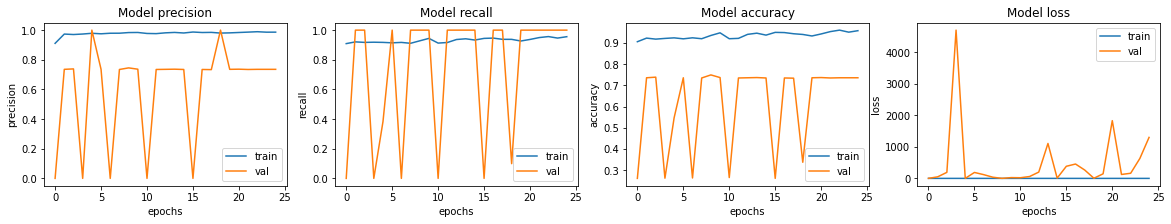

In [38]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [39]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(
    f"Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}"
)

39/39 [==============================] - 4s 108ms/step - loss: 0.6915 - accuracy: 0.5946 - precision: 0.9660 - recall: 0.3641
Loss: 0.6915163993835449,
Accuracy: 0.5945512652397156,
Precision: 0.9659863710403442,
Recall: 0.3641025722026825


## 데이터 증강 적용

데이터에 포함된 이미지를 보면 데이터 증강을 위해 좌우반전을 적용하여도 폐렴 판단에 큰 문제가 없을 것으로 생각됩니다.    
좌우반전 데이터 증강을 적용한 데이터셋을 사용한 모델의 성능을 확인합니다.

In [40]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label


def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(augment, num_parallel_calls=2)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 데이터 증강 적용 확인

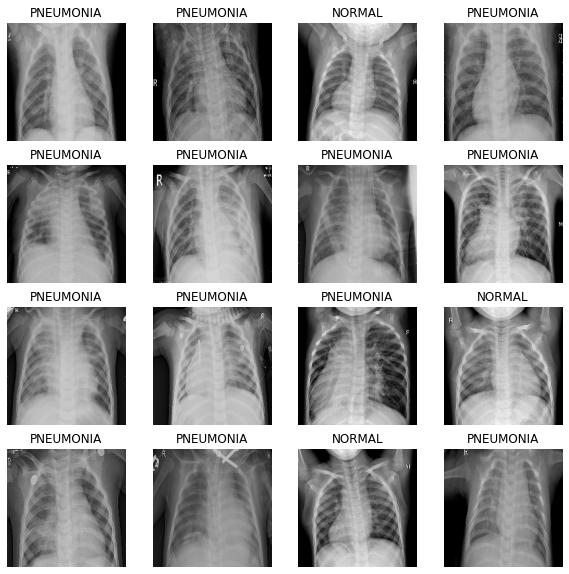

In [41]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 데이터 증강 적용 여부에 따른 성능 변화

In [42]:
weight_path = "checkpoint/weights_aug.h5"
checkpoint = ModelCheckpoint(
    filepath=weight_path, save_best_only=True, save_weights_only=True
)

with tf.device("/GPU:0"):
    model = build_model()
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=METRICS)
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[stopper, checkpoint],
    )

Epoch 1/25
261/261 [==============================] - 57s 183ms/step - loss: 0.8518 - accuracy: 0.4902 - precision: 0.7535 - recall: 0.4738 - val_loss: 0.8308 - val_accuracy: 0.2644 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
261/261 [==============================] - 48s 185ms/step - loss: 0.5489 - accuracy: 0.6923 - precision: 0.8964 - recall: 0.6629 - val_loss: 0.5754 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 187ms/step - loss: 0.3265 - accuracy: 0.8475 - precision: 0.9588 - recall: 0.8308 - val_loss: 0.5528 - val_accuracy: 0.7404 - val_precision: 0.7389 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 49s 188ms/step - loss: 0.2642 - accuracy: 0.8949 - precision: 0.9657 - recall: 0.8900 - val_loss: 0.4513 - val_accuracy: 0.7808 - val_precision: 0.7705 - val_recall: 0.9987
Epoch 5/25
261/261 [==============================] - 48s 185ms/step - loss: 0.2216 

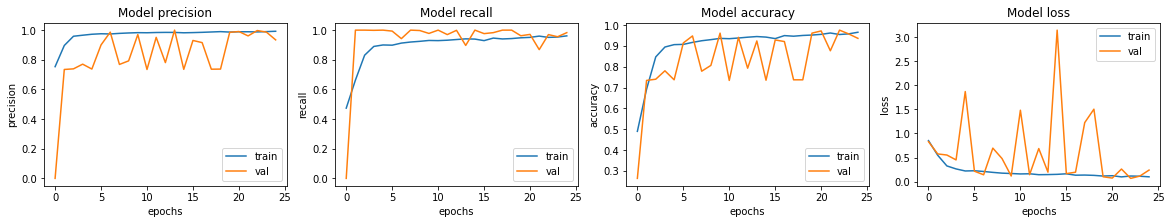

In [43]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [44]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(
    f"Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}"
)

39/39 [==============================] - 4s 107ms/step - loss: 1.0768 - accuracy: 0.7548 - precision: 0.7207 - recall: 0.9923
Loss: 1.0767697095870972,
Accuracy: 0.754807710647583,
Precision: 0.7206704020500183,
Recall: 0.9923076629638672


## 성능 비교

| batch size | class weight | dropout | batch norm | data aug | loss | acc | precision | recall |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| 16 | - | ✓ | ✓ | - | 0.8739 | 0.7965 | 0.7700 | 0.9615 |
| 16 | ✓ | ✓ | ✓ | - | 0.6296 | **0.8606** | **0.8301** | 0.9769 |
| 32 | ✓ |  ✓ | ✓ | - | 0.7726 | 0.7388 | 0.7083 | 0.9897 |
| 64 | ✓ |  ✓ | ✓ | - | **0.4352** | 0.8045 | 0.7839 | 0.9487 |
| 16 | ✓ | ✓ | - | - | (0.6931) | (0.6250) | (0.6250) | (1.0000) |
| 16 | ✓ | - | ✓ | - | (0.6915) | (0.5946) | (0.9660) | (0.3641) |
| 16 | ✓ | ✓ | ✓ | ✓ | 1.0768 | 0.7548 | 0.7207 | **0.9923** |

- 클래스 간  샘플 수 불균형을 해결하기 위한 방법을 적용하여 loss를 감소시키고 accuracy를 향상시킬 수 있었습니다.
- 데이터 증강을 적용하면 적용하지 않은 모델보다 정확도가 감소하였습니다.
- 배치 사이즈를 증가시키면 loss는 감소하였지만 accuracy는 경향을 찾기 어려웠습니다.
- 주어진 데이터셋에서 Dropout 또는 Batch Norm 중 하나를 사용하지 않으면 loss가 감소하지 않거나 크게 증가하여 수렴하지 못하였습니다.
- 수렴하지 못하여 제대로 학습이 이루어진 경우를 제외하고 생각하면, 모든 모델의 recall이 0.95이상으로 매우 높습니다. 폐렴이지만 폐렴이 아니라고 진단할 확률은 매우 낮습니다.

## 결론

- 모든 실험의 결과에서 train 또는 validation 데이터에 대한 accuracy보다 test 데이터에 대한 accuracy가 낮았습니다. 이는 과적합이 발생했음을 나타냅니다. 정규화와 조기중단 등 과적합을 방지하기 위한 시도들이 있었으나, 다른 시도들이 추가적으로 필요합니다.
- loss가 더 낮음에도 불구하고 accuracy가 더 낮은 경우가 있습니다. 클래스 간 샘플 수 차이가 크기 때문에 발생하는 것으로 보입니다.
- dropout 또는 batch norm을 적용하지 않는 경우, loss가 수렴하지 못하여 학습이 제대로 이루어지지 않았습니다.
- 클래스 불균형 문제를 해결하기 위한 방법을 적용하면 loss 감소와 accuracy 향상을 기대할 수 있습니다.
- 최종적으로 dropout, batch norm을 적용한 모델의 정확도가 가장 높았습니다. 해당 모델의 recall 역시 0.98 이상으로 높은 수치를 달성하여 폐렴 판단에 적절하다고 판단됩니다.

## 루브릭

|평가문항|상세기준|
|:--|:--|
|1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.|모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.|
|2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.|regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.|
|3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.|Accuracy 기준 85%에 도달하였다.|

### 루브릭 자체평가

1. 다양한 조건에 대해서 모델의 수렴 여부를 그래프를 통해 확인하였으며, 일부 모델은 정상적으로 학습이 진행되어 예측을 할 수 있었다.
2. 다양한 기법의 사용 여부에 따라 모델을 훈련 시키고 그 결과를 표의 형태로 표현, 비교를 수행하였다.
3. dropout과 batch norm을 적용하여 약 86%의 정확도를 달성하였다.